## Importar Librerias

In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Noticias_BCRP/notebooks")

In [ ]:
import pandas as pd
import numpy as np
from sklearn import  svm , model_selection
import lightgbm as lgb
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve,auc, classification_report,confusion_matrix
import seaborn as sns
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Word2Vec con size = 50 y mincount = 2



In [ ]:
size=50
min_count=2
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 14, 64862)

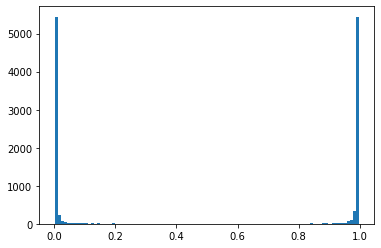

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

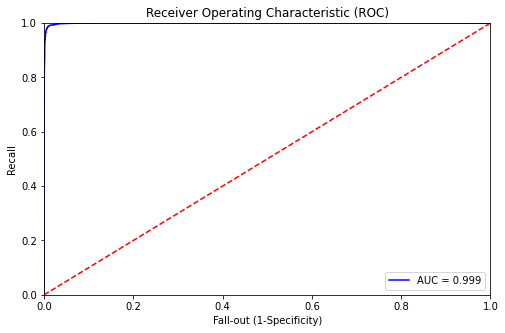

AUC score: 0.9990848805926916


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



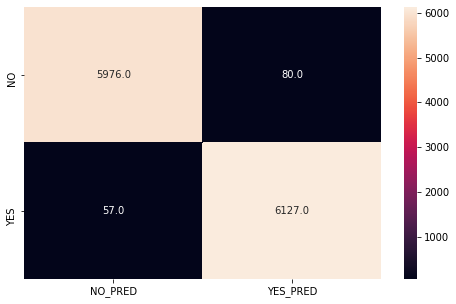

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 87, 124168)

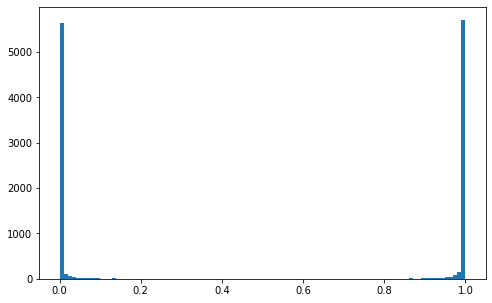

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

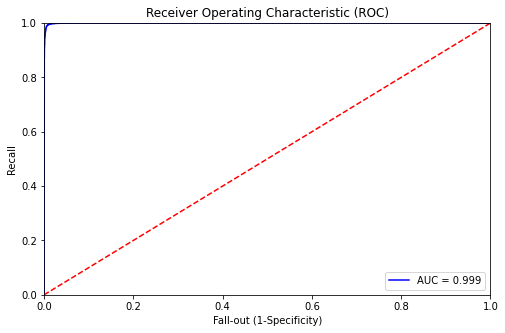

AUC score: 0.9993304593735741


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



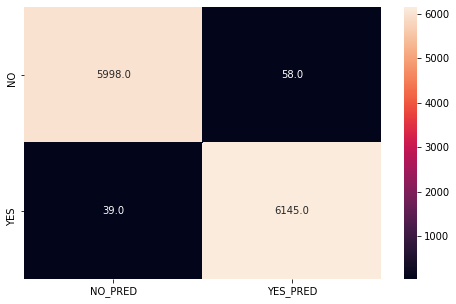

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
#binary_crossentropy, 

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
model= Sequential()
model.add(Dense( units,input_dim,activation))
model.add(Dropout(0.3))
model.compile(loss='binary_crossentropy',
              optimizer,
              metrics=['accuracy'])

# model.compile()
model.fit(x , y , batch_size, epochs)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 11s 222us/step - loss: 0.0301 - accuracy: 0.9903
Epoch 2/20
48957/48957 [==============================] - 11s 215us/step - loss: 0.0239 - accuracy: 0.9923
Epoch 3/20
48957/48957 [==============================] - 11s 215us/step - loss: 0.0227 - accuracy: 0.9930
Epoch 4/20
48957/48957 [==============================] - 11s 218us/step - loss: 0.0214 - accuracy: 0.9934
Epoch 5/20
48957/48957 [==============================] - 10s 211us/step - loss: 0.0213 - accuracy: 0.9936
Epoch 6/20
48957/48957 [==============================] - 10s 211us/step - loss: 0.0206 - accuracy: 0.9938
Epoch 7/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0197 - accuracy: 0.9941
Epoch 8/20
48957/48957 [==============================] - 10s 210us/step - loss: 0.0193 - accuracy: 0.9943
Epoch 9/20
48957/48957 [==============================] - 11s 221us/step - loss: 0.0191 - accuracy: 0.9943
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 209, 543274)

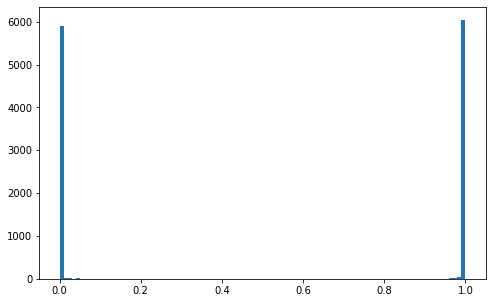

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

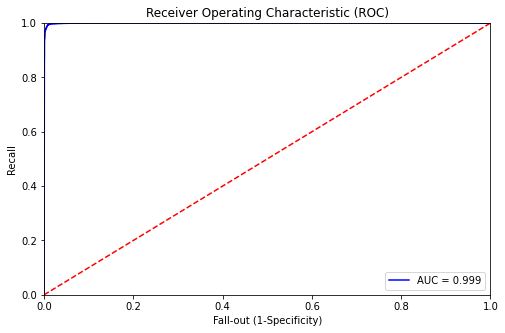

AUC score: 0.999312715859396


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



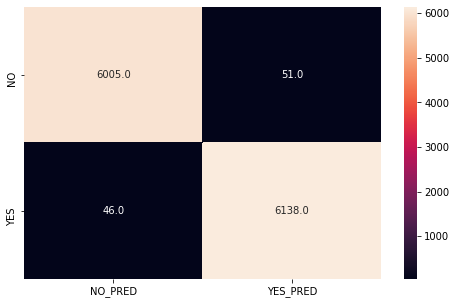

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Word2Vec con size = 50 y min_count = 5

In [ ]:
size=50
min_count=5
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
# train_data=lgb.Dataset(word2vec_train,label = y_train)
# ### definir los parámetros del modelo
# param = {'num_leaves':31,'max_depth':-1,'learning_rate':0.1}
# param['metric'] =['auc','binary_logloss']
# num_round=500
# ### entrenar el modelo Ligh GBM
# lg_model=lgb.train(param,train_data,num_round)

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 14, 262593)

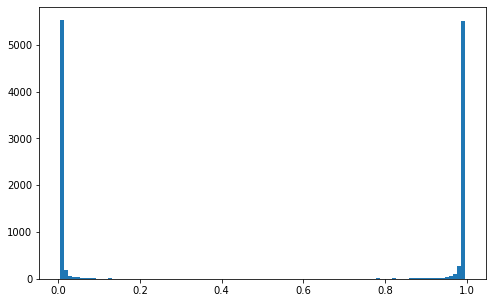

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

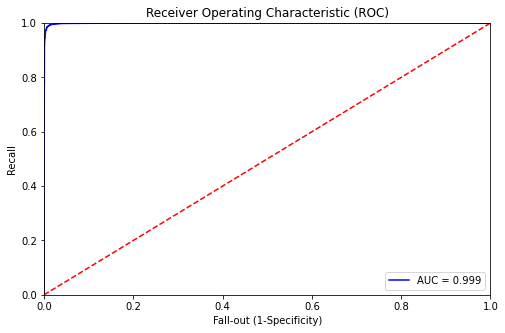

AUC score: 0.9991428106965432


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



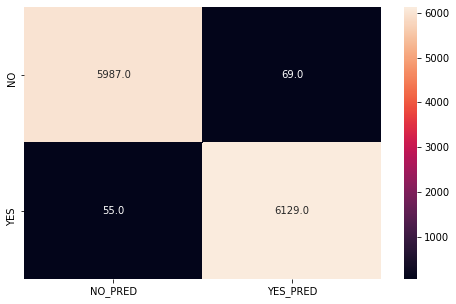

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
# from sklearn import svm
# svm.SVC(C=100,gamma=0.01,kernel="rbf")

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 88, 51807)

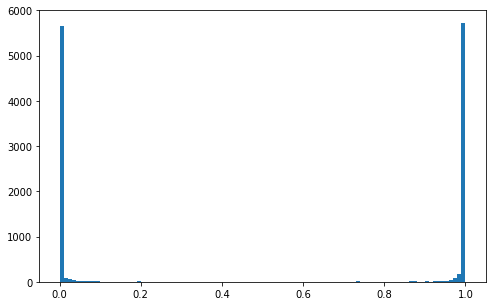

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

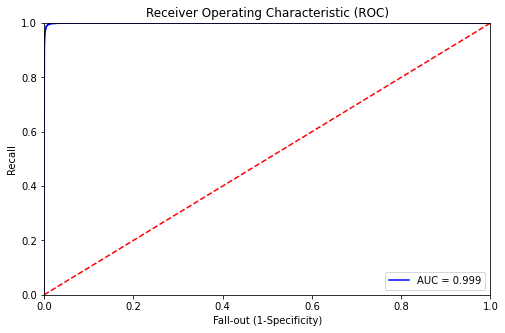

AUC score: 0.9994495905827627


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



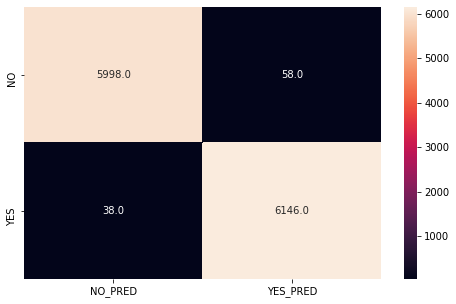

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 11s 218us/step - loss: 0.0296 - accuracy: 0.9903
Epoch 2/20
48957/48957 [==============================] - 10s 211us/step - loss: 0.0234 - accuracy: 0.9926
Epoch 3/20
48957/48957 [==============================] - 11s 217us/step - loss: 0.0224 - accuracy: 0.9930
Epoch 4/20
48957/48957 [==============================] - 10s 214us/step - loss: 0.0215 - accuracy: 0.9935
Epoch 5/20
48957/48957 [==============================] - 10s 213us/step - loss: 0.0199 - accuracy: 0.9939
Epoch 6/20
48957/48957 [==============================] - 10s 211us/step - loss: 0.0200 - accuracy: 0.9937
Epoch 7/20
48957/48957 [==============================] - 14s 284us/step - loss: 0.0193 - accuracy: 0.9941
Epoch 8/20
48957/48957 [==============================] - 10s 214us/step - loss: 0.0193 - accuracy: 0.9944
Epoch 9/20
48957/48957 [==============================] - 10s 213us/step - loss: 0.0186 - accuracy: 0.9943
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 210, 487606)

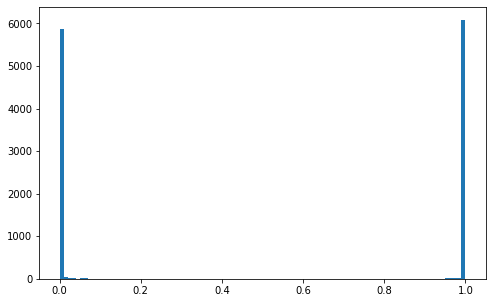

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

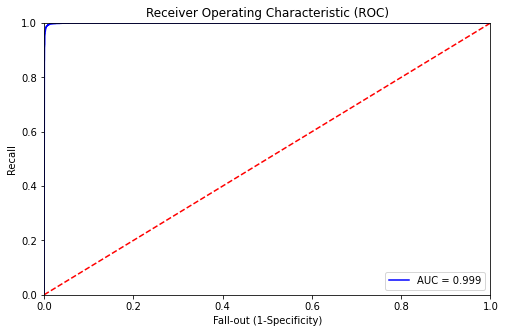

AUC score: 0.9993641306623305


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



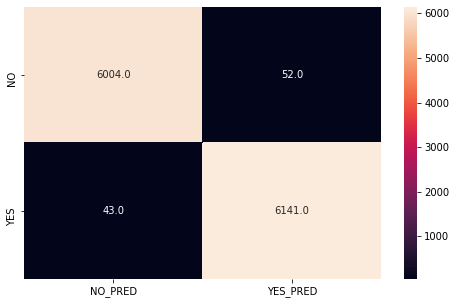

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Word2vec con size = 50 y min_count = 10

In [ ]:
size=50
min_count=10
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 13, 677602)

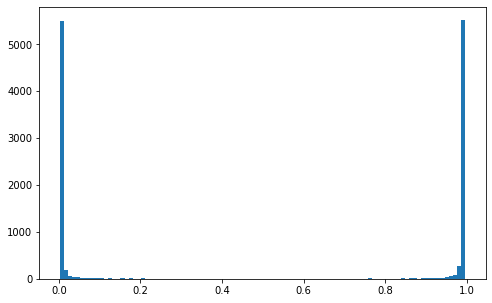

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

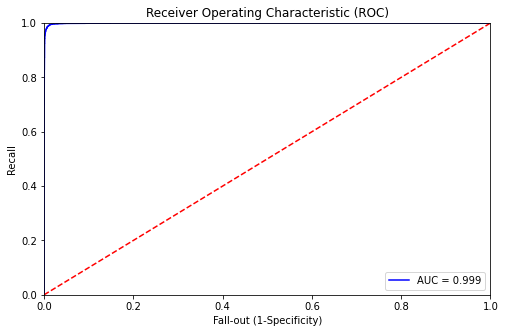

AUC score: 0.999153037582819


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



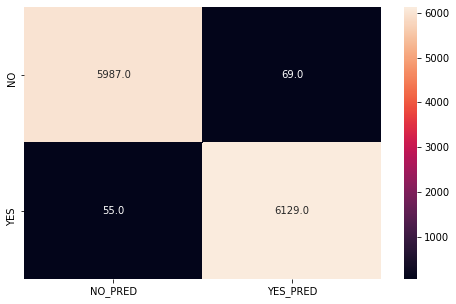

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 85, 426916)

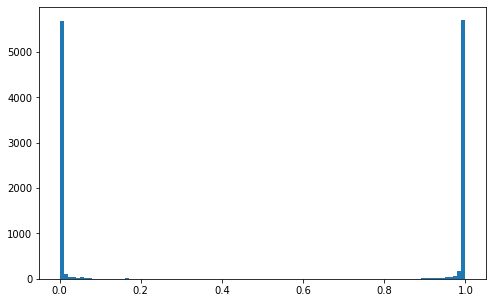

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

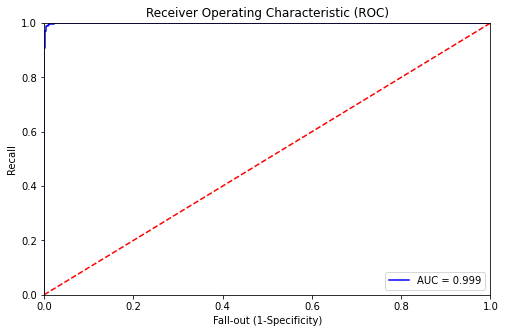

AUC score: 0.9993727420744035


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



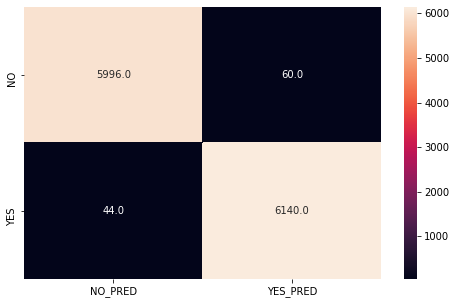

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 10s 207us/step - loss: 0.0304 - accuracy: 0.9899
Epoch 2/20
48957/48957 [==============================] - 10s 213us/step - loss: 0.0234 - accuracy: 0.9928
Epoch 3/20
48957/48957 [==============================] - 11s 215us/step - loss: 0.0216 - accuracy: 0.9934
Epoch 4/20
48957/48957 [==============================] - 10s 210us/step - loss: 0.0214 - accuracy: 0.9933
Epoch 5/20
48957/48957 [==============================] - 10s 208us/step - loss: 0.0199 - accuracy: 0.9940
Epoch 6/20
48957/48957 [==============================] - 10s 206us/step - loss: 0.0200 - accuracy: 0.9940
Epoch 7/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0192 - accuracy: 0.9941
Epoch 8/20
48957/48957 [==============================] - 10s 208us/step - loss: 0.0186 - accuracy: 0.9945
Epoch 9/20
48957/48957 [==============================] - 10s 197us/step - loss: 0.0183 - accuracy: 0.9944
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 198, 459399)

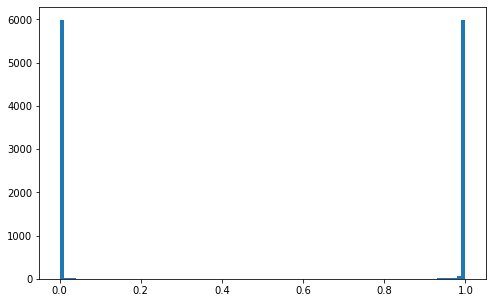

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

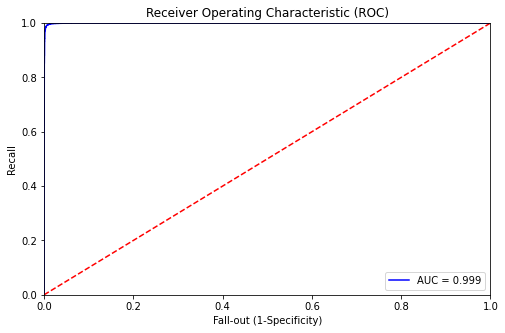

AUC score: 0.9994975474698417


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



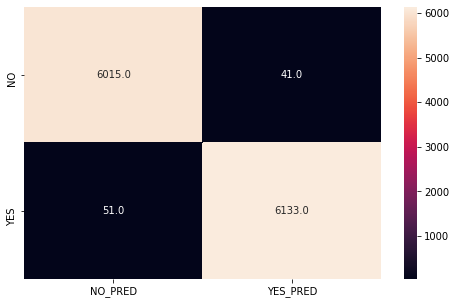

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Word2vec con size = 100 y min_count = 2

In [ ]:
size=100
min_count=2
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 26, 216531)

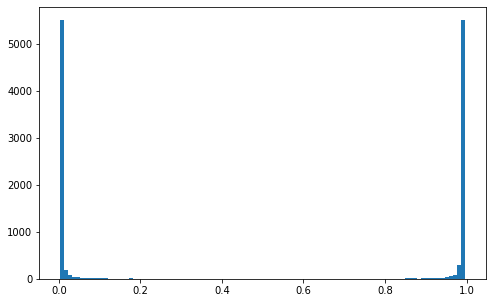

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

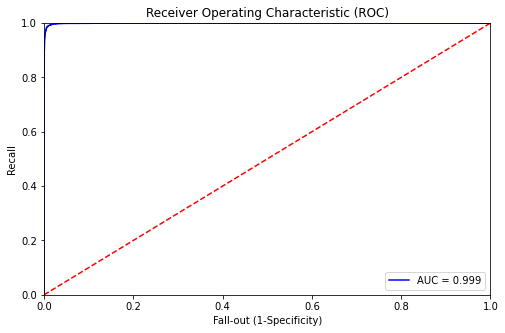

AUC score: 0.9993113273526432


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



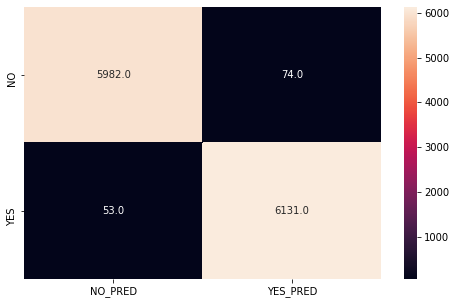

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 156, 545105)

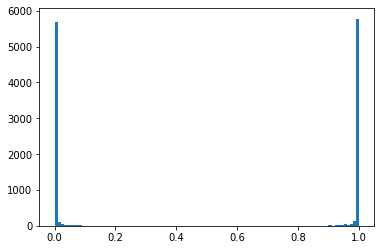

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

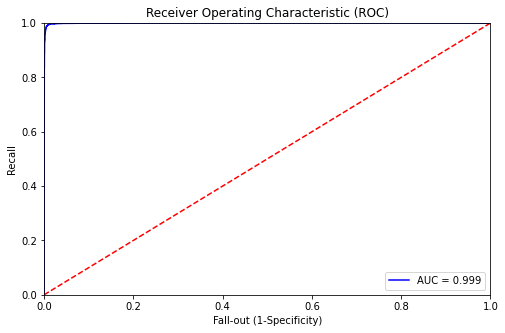

AUC score: 0.9992758269732602


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



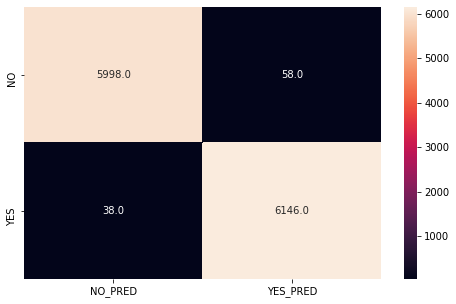

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 11s 220us/step - loss: 0.0297 - accuracy: 0.9902
Epoch 2/20
48957/48957 [==============================] - 10s 213us/step - loss: 0.0230 - accuracy: 0.9925
Epoch 3/20
48957/48957 [==============================] - 11s 216us/step - loss: 0.0214 - accuracy: 0.9933
Epoch 4/20
48957/48957 [==============================] - 11s 219us/step - loss: 0.0201 - accuracy: 0.9940
Epoch 5/20
48957/48957 [==============================] - 11s 217us/step - loss: 0.0198 - accuracy: 0.9941
Epoch 6/20
48957/48957 [==============================] - 11s 222us/step - loss: 0.0190 - accuracy: 0.9943
Epoch 7/20
48957/48957 [==============================] - 11s 216us/step - loss: 0.0168 - accuracy: 0.9949
Epoch 8/20
48957/48957 [==============================] - 11s 220us/step - loss: 0.0173 - accuracy: 0.9950
Epoch 9/20
48957/48957 [==============================] - 11s 224us/step - loss: 0.0163 - accuracy: 0.9952
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 216, 567434)

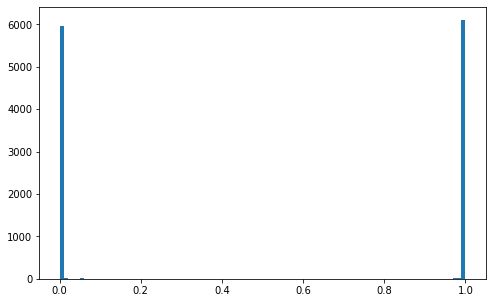

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

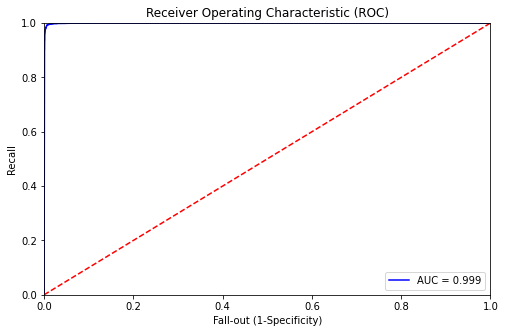

AUC score: 0.9991888717378637


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



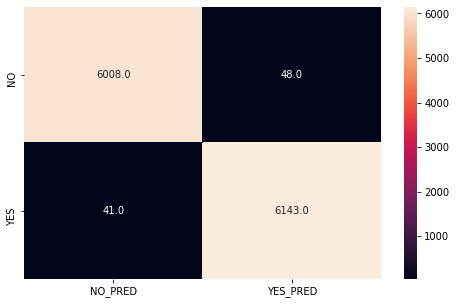

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Word2vec con size = 100 y min_count = 5

In [ ]:
size=100
min_count=5
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 26, 272268)

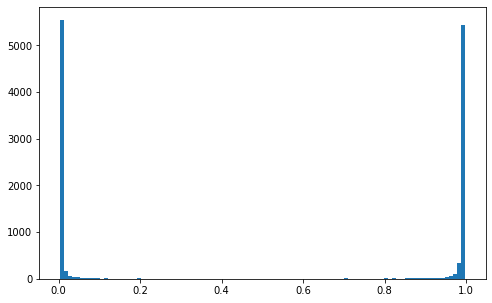

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

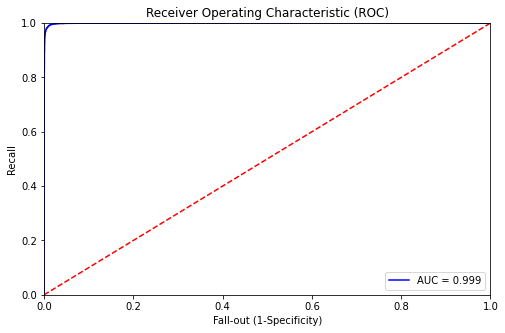

AUC score: 0.9992178968694087


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



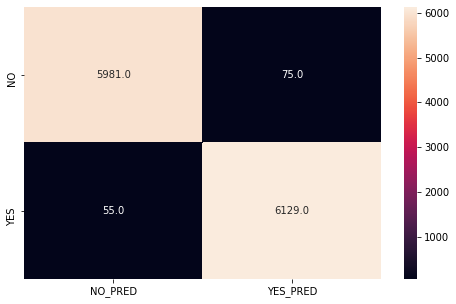

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 158, 705094)

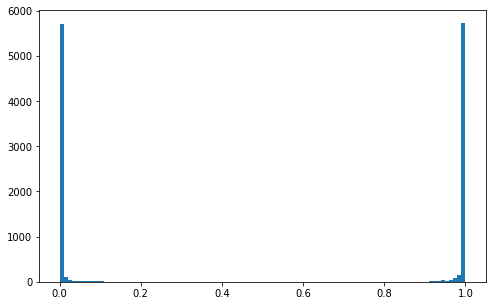

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

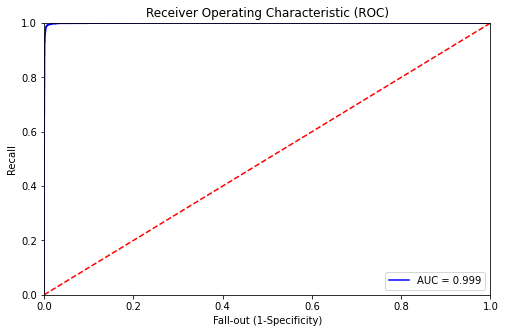

AUC score: 0.9991738651841117


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



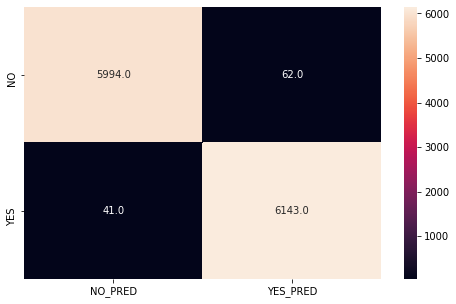

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 11s 219us/step - loss: 0.0303 - accuracy: 0.9903
Epoch 2/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0232 - accuracy: 0.9926
Epoch 3/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0219 - accuracy: 0.9935
Epoch 4/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0205 - accuracy: 0.9937
Epoch 5/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0197 - accuracy: 0.9942
Epoch 6/20
48957/48957 [==============================] - 10s 214us/step - loss: 0.0184 - accuracy: 0.9945
Epoch 7/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0173 - accuracy: 0.9950
Epoch 8/20
48957/48957 [==============================] - 10s 208us/step - loss: 0.0170 - accuracy: 0.9952
Epoch 9/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0165 - accuracy: 0.9952
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 207, 412833)

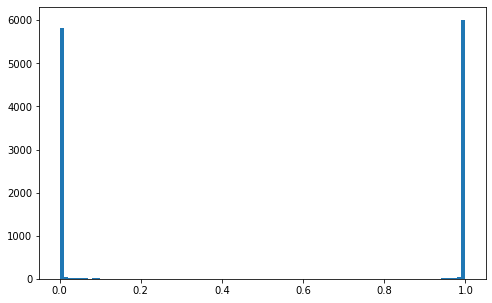

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

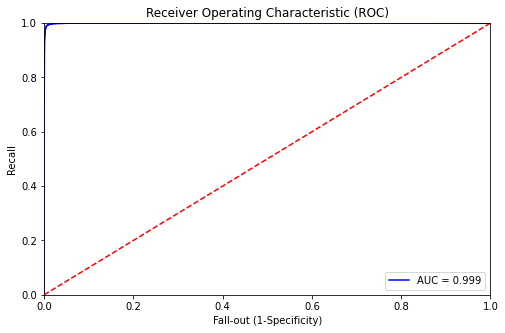

AUC score: 0.9994679081910789


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



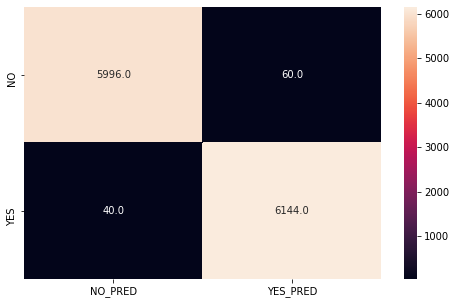

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Word2vec con size = 100 y min_count = 10

In [ ]:
size=100
min_count=10
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 25, 808572)

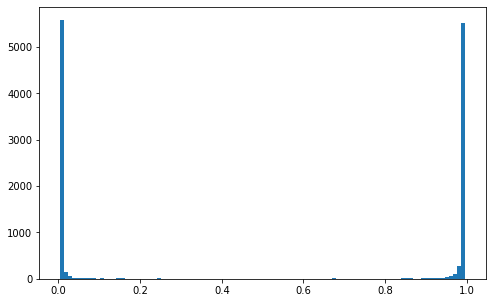

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

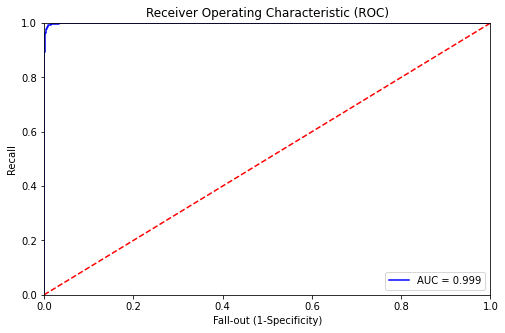

AUC score: 0.9993218479615011


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



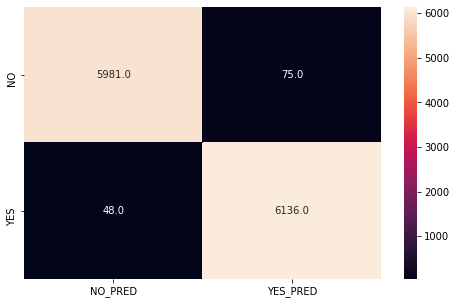

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 156, 681604)

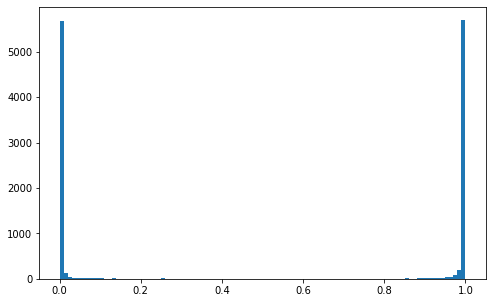

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

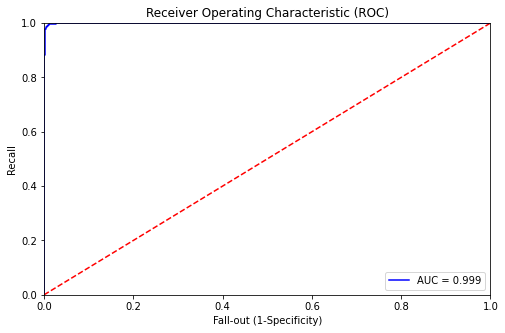

AUC score: 0.999225239933967


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



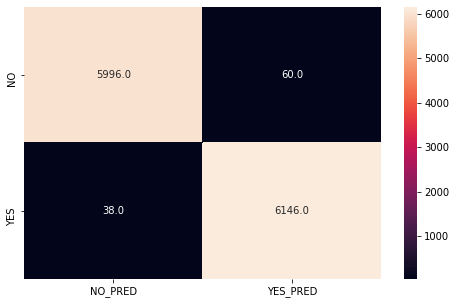

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 11s 215us/step - loss: 0.0312 - accuracy: 0.9898
Epoch 2/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0231 - accuracy: 0.9927
Epoch 3/20
48957/48957 [==============================] - 10s 210us/step - loss: 0.0217 - accuracy: 0.9935
Epoch 4/20
48957/48957 [==============================] - 10s 210us/step - loss: 0.0204 - accuracy: 0.9938
Epoch 5/20
48957/48957 [==============================] - 10s 210us/step - loss: 0.0197 - accuracy: 0.9944
Epoch 6/20
48957/48957 [==============================] - 10s 213us/step - loss: 0.0177 - accuracy: 0.9949
Epoch 7/20
48957/48957 [==============================] - 10s 210us/step - loss: 0.0170 - accuracy: 0.9952
Epoch 8/20
48957/48957 [==============================] - 10s 211us/step - loss: 0.0169 - accuracy: 0.9953
Epoch 9/20
48957/48957 [==============================] - 10s 212us/step - loss: 0.0160 - accuracy: 0.9956
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 206, 227865)

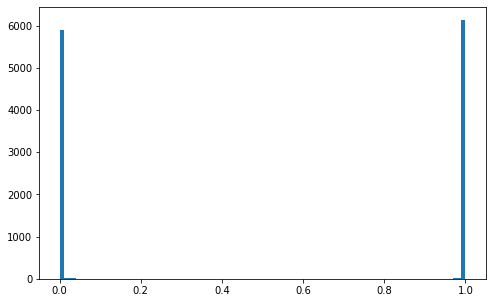

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

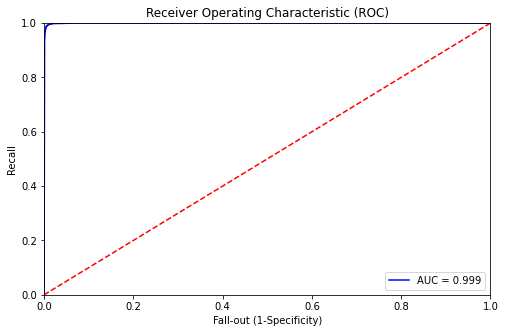

AUC score: 0.9991846394624727


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



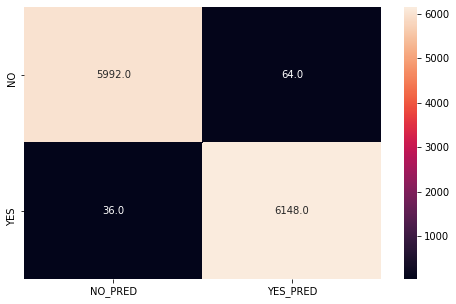

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Word2vec con size = 200 y min_count = 2

In [ ]:
size=200
min_count=2
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 48, 693727)

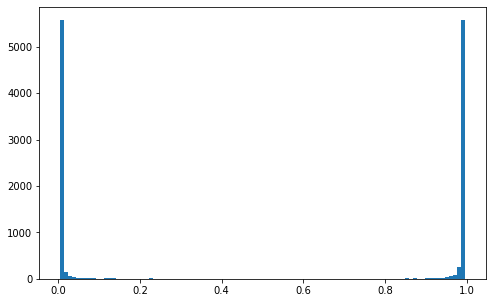

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

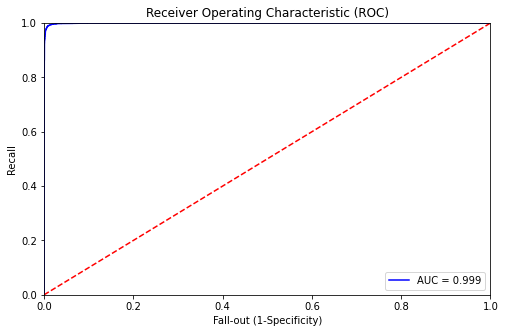

AUC score: 0.9993376822788942


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



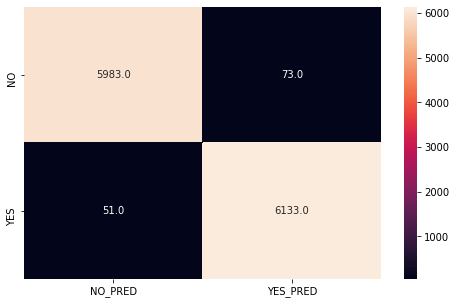

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 684, 226692)

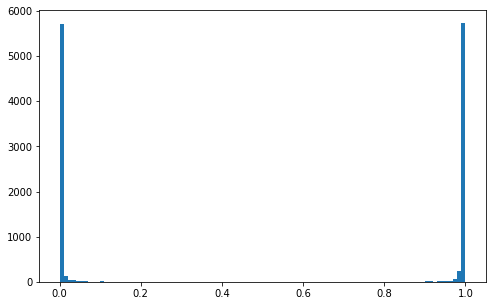

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

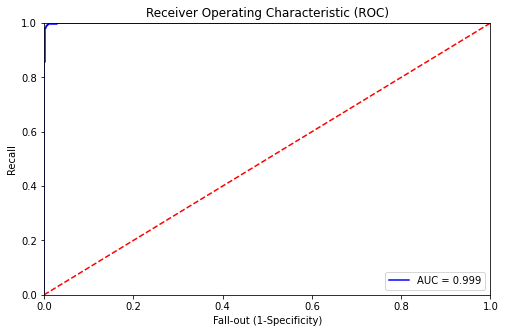

AUC score: 0.9991713284890824


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



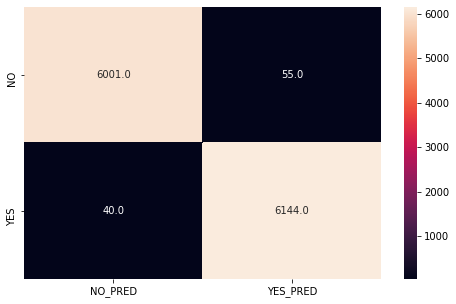

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 12s 243us/step - loss: 0.0304 - accuracy: 0.9902
Epoch 2/20
48957/48957 [==============================] - 12s 238us/step - loss: 0.0242 - accuracy: 0.9929
Epoch 3/20
48957/48957 [==============================] - 12s 239us/step - loss: 0.0226 - accuracy: 0.9932
Epoch 4/20
48957/48957 [==============================] - 14s 280us/step - loss: 0.0208 - accuracy: 0.9940
Epoch 5/20
48957/48957 [==============================] - 14s 279us/step - loss: 0.0201 - accuracy: 0.9944
Epoch 6/20
48957/48957 [==============================] - 13s 273us/step - loss: 0.0189 - accuracy: 0.9945
Epoch 7/20
48957/48957 [==============================] - 14s 279us/step - loss: 0.0188 - accuracy: 0.9947
Epoch 8/20
48957/48957 [==============================] - 13s 267us/step - loss: 0.0173 - accuracy: 0.9953
Epoch 9/20
48957/48957 [==============================] - 14s 277us/step - loss: 0.0165 - accuracy: 0.9954
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 267, 139758)

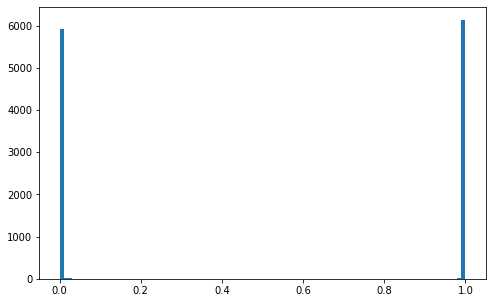

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

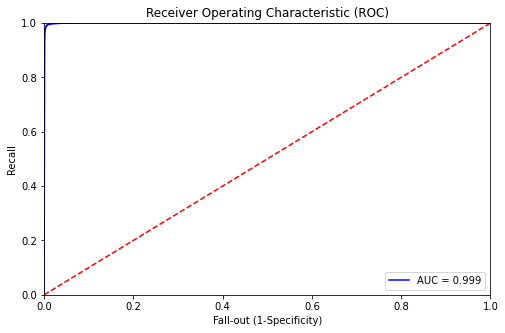

AUC score: 0.9990488595232765


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



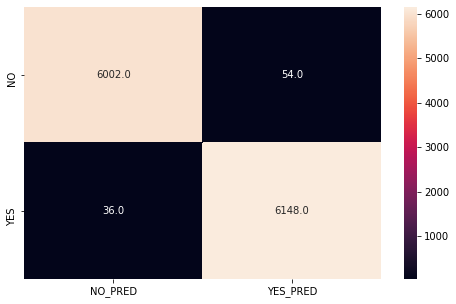

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Word2vec con size = 200 y min_count = 5

In [ ]:
size=200
min_count=5
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 53, 80014)

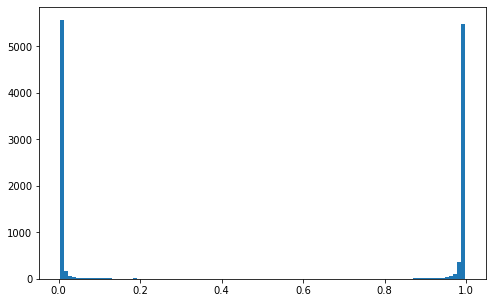

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

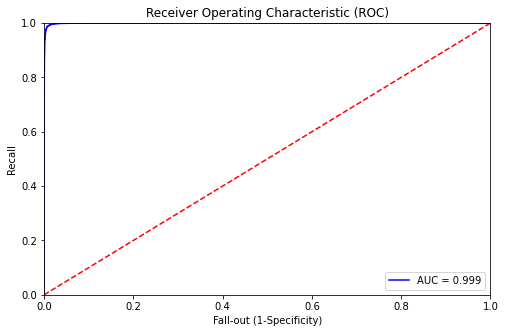

AUC score: 0.9991543459834131


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



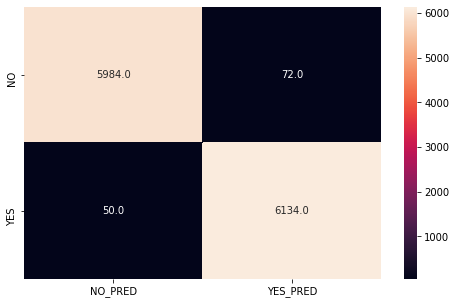

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 716, 434780)

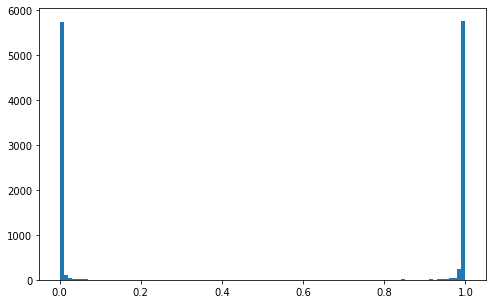

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

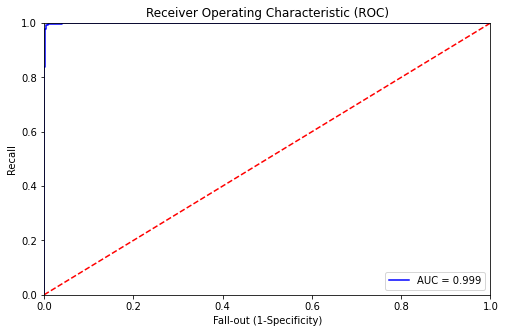

AUC score: 0.9992593918596762


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



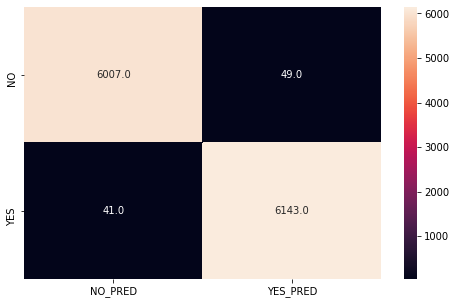

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 11s 220us/step - loss: 0.0307 - accuracy: 0.9904
Epoch 2/20
48957/48957 [==============================] - 11s 219us/step - loss: 0.0235 - accuracy: 0.9928
Epoch 3/20
48957/48957 [==============================] - 11s 223us/step - loss: 0.0231 - accuracy: 0.9932
Epoch 4/20
48957/48957 [==============================] - 11s 220us/step - loss: 0.0208 - accuracy: 0.9937
Epoch 5/20
48957/48957 [==============================] - 11s 226us/step - loss: 0.0192 - accuracy: 0.9946
Epoch 6/20
48957/48957 [==============================] - 11s 228us/step - loss: 0.0186 - accuracy: 0.9949
Epoch 7/20
48957/48957 [==============================] - 11s 220us/step - loss: 0.0176 - accuracy: 0.9949
Epoch 8/20
48957/48957 [==============================] - 11s 219us/step - loss: 0.0169 - accuracy: 0.9954
Epoch 9/20
48957/48957 [==============================] - 11s 218us/step - loss: 0.0159 - accuracy: 0.9952
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 217, 861728)

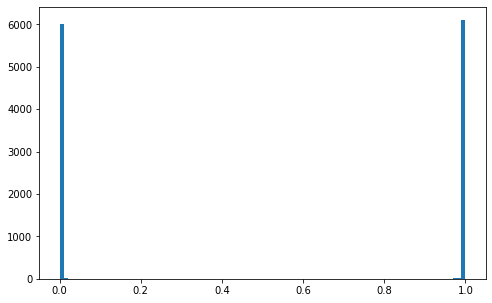

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

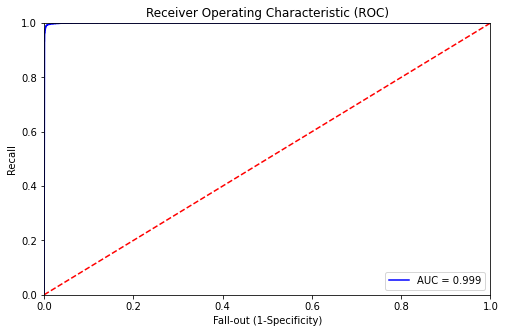

AUC score: 0.999281247490007


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



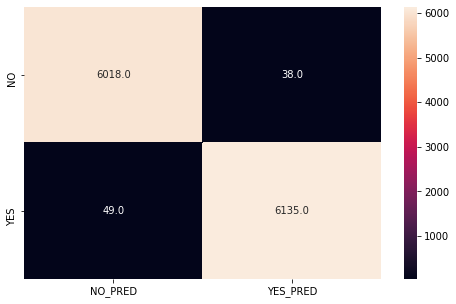

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

## Word2vec con size = 200 y min_count = 10

In [ ]:
size=200
min_count=10
name_file=str(size)+"_"+str(min_count)
# modelo=pickle.load(open("../models/word2vec/modelo{}.pkl".format(name_file),"rb"))
# ### guardar el valor estandar
# scaler=pickle.load(open("../models/word2vec/scaler{}.pkl".format(name_file),"rb"))
### Cargar el modelo word2vec
word2vec_train=np.load("../data/preprocessed/word2vec/word2vec_train{}.npy".format(name_file))
word2vec_test=np.load("../data/preprocessed/word2vec/word2vec_test{}.npy".format(name_file))
### Cargar los valores de la etiqueta
y_train=pd.read_pickle("../data/preprocessed/df_train.pkl")["Target"]
y_test=pd.read_pickle("../data/preprocessed/df_test.pkl")["Target"]

#### Light GBM

In [ ]:
train_data=lgb.Dataset(word2vec_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':150,'objective':'binary','max_depth':7,'learning_rate':0.01,'max_bin':200}
param['metric'] =['auc','binary_logloss']
num_round=500
start = datetime.now()
### entrenar el modelo Ligh GBM
lg_model=lgb.train(param,train_data,num_round)
stop=datetime.now()
execution_time_lg=stop-start
execution_time_lg

datetime.timedelta(0, 50, 245606)

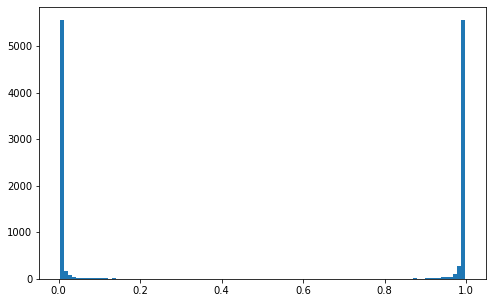

In [ ]:
pred_lg=lg_model.predict(word2vec_test)
plt.hist(pred_lg,bins=100)
plt.show()

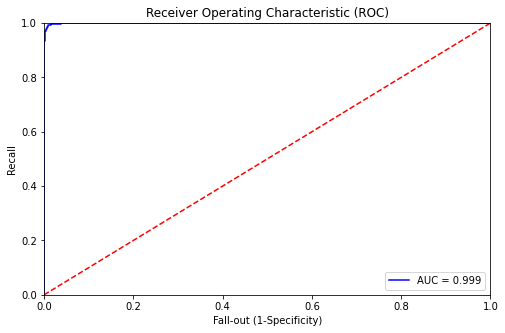

AUC score: 0.9993028360998083


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_lg)
roc_auc_lg = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_lg)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_lg)

In [ ]:
### prediccion del modelo
pred_lg[pred_lg>=0.5]=1
pred_lg[pred_lg<0.5]=0
print(classification_report(y_test, pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



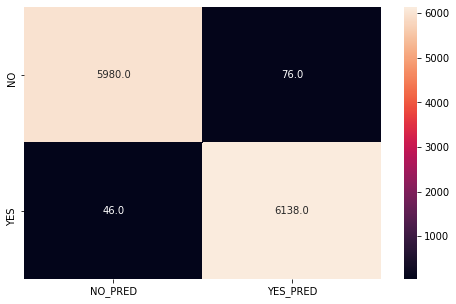

In [ ]:
### matriz de confusion
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_lg, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Support Vector Machine

In [ ]:
def svc_param(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10,100]
    gammas = [0.000001, 0.0001, 0.01, 1]
    kernels = ['rbf','linear']
    param_grid = {'C': Cs, 'gamma' : gammas,'kernel':kernels}
    grid_search = model_selection.GridSearchCV(svm.SVC(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
start = datetime.now()
# fitting=svc_param(promVect_train, Y_train, 5)
# model = svm.SVC(C=fitting['C'],gamma=fitting['gamma'],kernel=fitting['kernel'],probability=True)
svm_model = svm.SVC(C=100,gamma=0.01,kernel="rbf",probability=True)
svm_model.fit(word2vec_train,y_train)
stop=datetime.now()
execution_time_svm=stop-start
execution_time_svm

datetime.timedelta(0, 575, 686676)

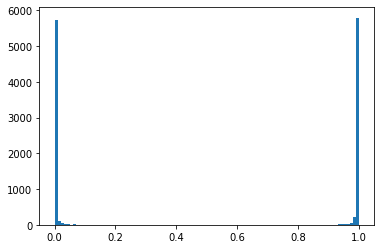

In [ ]:
pred_svm = svm_model.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_svm,bins=100)
plt.show()

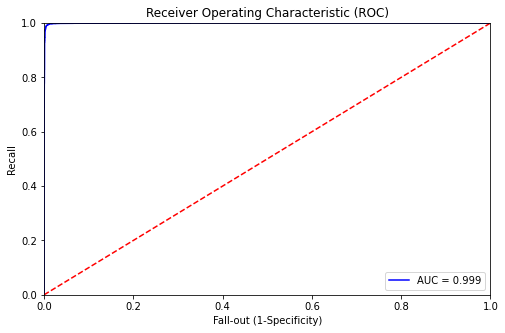

AUC score: 0.9993232231172277


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_svm)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_svm)

In [ ]:
### prediccion del modelo
pred_svm[pred_svm>=0.5]=1
pred_svm[pred_svm<0.5]=0
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



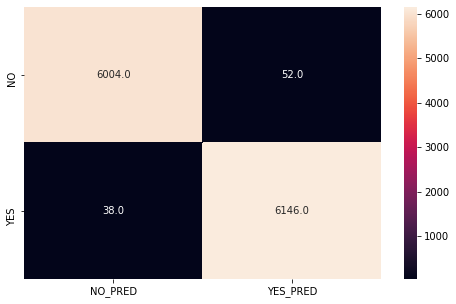

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

In [ ]:
import pickle
pickle.dump(svm_model,open("../models/word2vec/svm_model200_10.pkl","wb"))

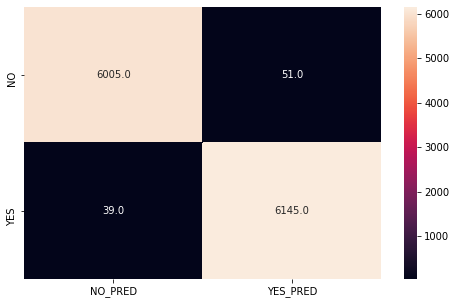

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_svm, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()

#### Redes Neuronales

In [ ]:
one_hot =[]
for i in y_train:
    aux=[]
    for j in [0,1]:
        if i==j:
            aux.append(1)
        else:
            aux.append(0)
    one_hot.append(aux)
one_hot = np.array(one_hot)

In [ ]:
model_rnn = Sequential()
model_rnn.add(Dense(1024,input_dim=len(word2vec_train[0]),activation="relu"))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(512,activation="relu"))
model_rnn.add(Dense(len(one_hot[0]),activation="sigmoid"))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model_rnn.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
start=datetime.now()
model_rnn.fit(word2vec_train,one_hot,epochs=20,batch_size=64)
stop=datetime.now()
execution_time_rnn=stop-start
execution_time_rnn

Epoch 1/20
48957/48957 [==============================] - 12s 238us/step - loss: 0.0321 - accuracy: 0.9901
Epoch 2/20
48957/48957 [==============================] - 12s 236us/step - loss: 0.0244 - accuracy: 0.9925
Epoch 3/20
48957/48957 [==============================] - 12s 236us/step - loss: 0.0223 - accuracy: 0.9931
Epoch 4/20
48957/48957 [==============================] - 12s 239us/step - loss: 0.0213 - accuracy: 0.9936
Epoch 5/20
48957/48957 [==============================] - 12s 238us/step - loss: 0.0198 - accuracy: 0.9941
Epoch 6/20
48957/48957 [==============================] - 14s 293us/step - loss: 0.0183 - accuracy: 0.9945
Epoch 7/20
48957/48957 [==============================] - 15s 303us/step - loss: 0.0182 - accuracy: 0.9950
Epoch 8/20
48957/48957 [==============================] - 13s 265us/step - loss: 0.0176 - accuracy: 0.9953
Epoch 9/20
48957/48957 [==============================] - 11s 234us/step - loss: 0.0162 - accuracy: 0.9955
Epoch 10/20
48957/48957 [============

datetime.timedelta(0, 241, 939904)

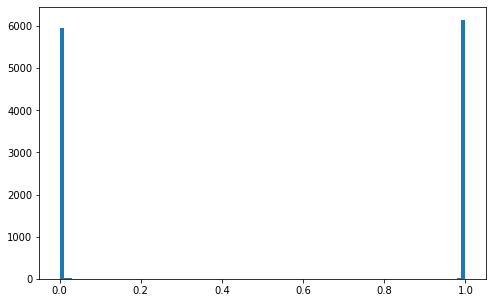

In [ ]:
pred_rnn=model_rnn.predict_proba(word2vec_test)[:,-1]
plt.hist(pred_rnn,bins=100)
plt.show()

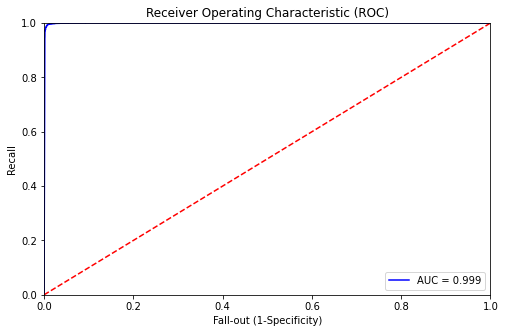

AUC score: 0.9989966436587537


In [ ]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, pred_rnn)
roc_auc_rnn = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc_rnn)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc_rnn)

In [ ]:
### prediccion del modelo
pred_rnn[pred_rnn>=0.5]=1
pred_rnn[pred_rnn<0.5]=0
print(classification_report(y_test, pred_rnn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6056
           1       0.99      0.99      0.99      6184

    accuracy                           0.99     12240
   macro avg       0.99      0.99      0.99     12240
weighted avg       0.99      0.99      0.99     12240



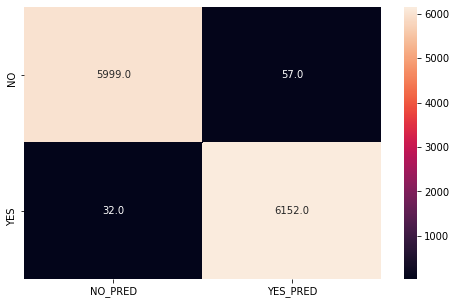

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
conf = confusion_matrix(y_test, pred_rnn, labels = [0,1])
label_y = ['NO','YES']
label_x = ['NO_PRED', 'YES_PRED']
sns.heatmap(conf, annot=True, xticklabels=label_x, yticklabels=label_y,fmt=".1f")
plt.show()